In [1]:
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

try:
    from rikabplotlib.plot_utils import newplot, stamp, add_whitespace
except ImportError:
    from utils.plot_utils import newplot, stamp, add_whitespace
from utils.data_utils import load_data
from config import base_dir



from sklearn.metrics import roc_auc_score, roc_curve, auc

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))

2024-03-13 00:43:56.469192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


Num GPUs Available:  0
GPUs Available:  []


# Parameters and Data

Define the observable $\mathcal{O}^{(n)} = \sum_i z_i (c_1 + c_2 \log^n(\theta_i + c_3))$

In [2]:
# Parameters 
train = 1#250000
val = 1#25000
test = 1#25000
k_order = 1

epochs = 50
batch_size=512
callbacks =None
verbose = 2

# directory = f"/n/home01/rikab/moment/models/O{k_order}/"
###########

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [k_order,] #
input_dim = 2
output_dim = 1


max_L = 2**(8-k_order)
F_width = 100
Phi_width = 100


def log_features(x):


    a = -3.5
    b = -1.0
    c = 0.005

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.log(rs + c)

    # ls = rs

    l_list = []

    for n in range(4 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return l_list


def exp_features(x):

    a = 1
    b = 0.16
    c = 0.15

    zs = x[:,0]

    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg

    rs = np.sqrt(np.sum(np.square(x[:,1:3]), axis = 1))
    ls = a + b*np.exp(- rs**2 / c **2)

    # ls = rs

    l_list = []

    for n in range(4 + 1):

        l_list.append(np.sum(zs * np.power(ls, n)))
    


    return l_list

# Data 
X, Y = load_data("qg", train, val, test)

print("Data loaded!")


def cumulants(x):

    x[4,:] = np.nan_to_num(np.power(x[4,:] - 4*x[3,:]*x[1,:] - 3*x[2,:]**2 + 12*x[2,:]*x[1,:]**2 - 6*x[1,:]**4, 1/2))
    x[3,:] = np.nan_to_num(np.power(x[3,:] - 3*x[2,:]*x[1,:] + 2*x[1,:]**3, 1/3))
    x[2,:] = np.nan_to_num(np.power(x[2,:] - x[1,:]**2, 1/4))

    return x

# Data 
X, Y = qg_jets.load(train+val+test)

print("Data loaded!")


X = X[:,:,:3].astype(np.float32)
Y2 = to_categorical(Y, num_classes=2)
features = []
e_features = []
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

    features.append((log_features(x)))
    e_features.append((exp_features(x)))

features = cumulants(np.array(features))
e_features = (np.array(e_features))

# stack
new_array = np.zeros((features.shape[0], features.shape[1] + e_features.shape[1]))

for i in range(5):
    new_array[:,2*i] = features[:,i]
    new_array[:,2*i+1] = e_features[:,i]




features = new_array

print(features.shape)





AssertionError: bad parameters: negative num_train

# Tensorflow fit

Fit to the function:

$F(\mathcal{O}) = \sigma(w_0 + \sum_{i=1}^k w_i(\mathcal{O}^{(i)} - c_i)^2)$

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

class CustomLayer(Layer):
    def __init__(self, input_dim):
        super(CustomLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim,1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_dim,1), initializer="random_normal", trainable=True)

    def call(self, inputs):
  
        return tf.reduce_sum(self.w[:,0] * (inputs - self.b[:,0])**2, axis=-1)


def custom_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true, y_pred, from_logits=False)

def train_model(k_order):

    # Data preparation 
    (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(features[:, 0:2*(k_order+1)], Y, val=val, test=test)

    # Model setup
    input_shape = (2*(k_order+1),)  
    input_data = Input(shape=input_shape)
    custom_layer = CustomLayer(2*(k_order+1))
    cl = custom_layer(input_data)
    output = tf.sigmoid(cl)
    model = Model(inputs=input_data, outputs=output)

    # Training setup
    optimizer = Adam(learning_rate=0.010)
    batch_size = 2*512
    epochs = 100

    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = custom_loss(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Validation
        if (epoch + 1) % 10 == 0:
            y_pred = model.predict(X_val)
            auc = roc_auc_score(Y_val, y_pred)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, AUC: {auc}")

    # Get the optimized values of w and c
    optimized_w = custom_layer.w.numpy()
    optimized_b = custom_layer.b.numpy()
    print("Optimized w:", optimized_w)
    print("Optimized b:", optimized_b)

    return model

782/782 [==============================] - 0s 371us/step
Epoch 10/100, Loss: 0.5837305188179016, AUC: 0.7673530159813828
782/782 [==============================] - 0s 413us/step
Epoch 20/100, Loss: 0.5816572904586792, AUC: 0.772402392376969
782/782 [==============================] - 0s 424us/step
Epoch 30/100, Loss: 0.5811188817024231, AUC: 0.7737853710002602
782/782 [==============================] - 0s 446us/step
Epoch 40/100, Loss: 0.5805916786193848, AUC: 0.77445291441763
782/782 [==============================] - 0s 376us/step
Epoch 50/100, Loss: 0.5801761150360107, AUC: 0.7748730990837829
782/782 [==============================] - 0s 450us/step
Epoch 60/100, Loss: 0.5798518061637878, AUC: 0.775170065303184
782/782 [==============================] - 0s 406us/step
Epoch 70/100, Loss: 0.5796043872833252, AUC: 0.7754054238996566
782/782 [==============================] - 0s 392us/step
Epoch 80/100, Loss: 0.5794073939323425, AUC: 0.7755875228069359
782/782 [===========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 406us/step
Epoch 10/100, Loss: 0.5987793207168579, AUC: 0.7161097053159451
782/782 [==============================] - 0s 427us/step
Epoch 20/100, Loss: 0.5949178338050842, AUC: 0.7179358543273053
782/782 [==============================] - 0s 462us/step
Epoch 30/100, Loss: 0.5929486155509949, AUC: 0.7186910741135548
782/782 [==============================] - 0s 401us/step
Epoch 40/100, Loss: 0.5922154188156128, AUC: 0.7189748212001306
782/782 [==============================] - 0s 375us/step
Epoch 50/100, Loss: 0.5914430022239685, AUC: 0.719328436126172
782/782 [==============================] - 0s 365us/step
Epoch 60/100, Loss: 0.5912491679191589, AUC: 0.7193999649710285
782/782 [==============================] - 0s 408us/step
Epoch 70/100, Loss: 0.5913259387016296, AUC: 0.7194647441812629
782/782 [==============================] - 0s 431us/step
Epoch 80/100, Loss: 0.5913079380989075, AUC: 0.7196039293921266
782/782 [========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 533us/step
Epoch 10/100, Loss: 0.5697968006134033, AUC: 0.767481400601546
782/782 [==============================] - 0s 411us/step
Epoch 20/100, Loss: 0.5640395283699036, AUC: 0.7722198465127862
782/782 [==============================] - 0s 413us/step
Epoch 30/100, Loss: 0.5626929998397827, AUC: 0.7734999103732896
782/782 [==============================] - 0s 389us/step
Epoch 40/100, Loss: 0.5620541572570801, AUC: 0.7741702898795598
782/782 [==============================] - 0s 376us/step
Epoch 50/100, Loss: 0.5616579055786133, AUC: 0.7746122729559068
782/782 [==============================] - 0s 419us/step
Epoch 60/100, Loss: 0.5613929033279419, AUC: 0.7749360689678689
782/782 [==============================] - 0s 362us/step
Epoch 70/100, Loss: 0.561216413974762, AUC: 0.7751888593000422
782/782 [==============================] - 0s 384us/step
Epoch 80/100, Loss: 0.5611055493354797, AUC: 0.775392378621728
782/782 [==========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 371us/step
Epoch 10/100, Loss: 0.5647047162055969, AUC: 0.7709663237811382
782/782 [==============================] - 0s 358us/step
Epoch 20/100, Loss: 0.5577585101127625, AUC: 0.7761714122742667
782/782 [==============================] - 0s 379us/step
Epoch 30/100, Loss: 0.555650532245636, AUC: 0.7775978203480334
782/782 [==============================] - 0s 407us/step
Epoch 40/100, Loss: 0.5551077127456665, AUC: 0.7782397771021343
782/782 [==============================] - 0s 428us/step
Epoch 50/100, Loss: 0.5548390746116638, AUC: 0.7786116249094772
782/782 [==============================] - 0s 459us/step
Epoch 60/100, Loss: 0.5547313690185547, AUC: 0.7789659941002534
782/782 [==============================] - 0s 458us/step
Epoch 70/100, Loss: 0.5555553436279297, AUC: 0.7800416394279291
782/782 [==============================] - 0s 403us/step
Epoch 80/100, Loss: 0.5556817054748535, AUC: 0.7811198895878799
782/782 [========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 430us/step
Epoch 10/100, Loss: 0.6042665839195251, AUC: 0.7669274928227628
782/782 [==============================] - 0s 479us/step
Epoch 20/100, Loss: 0.599791407585144, AUC: 0.7728672512361842
782/782 [==============================] - 0s 447us/step
Epoch 30/100, Loss: 0.5981070399284363, AUC: 0.7745108957508804
782/782 [==============================] - 0s 449us/step
Epoch 40/100, Loss: 0.5972262620925903, AUC: 0.775289149726424
782/782 [==============================] - 0s 492us/step
Epoch 50/100, Loss: 0.5969145894050598, AUC: 0.7757424473990646
782/782 [==============================] - 0s 479us/step
Epoch 60/100, Loss: 0.5965882539749146, AUC: 0.776687380016005
782/782 [==============================] - 0s 463us/step
Epoch 70/100, Loss: 0.5956950783729553, AUC: 0.7775268123273898
782/782 [==============================] - 0s 431us/step
Epoch 80/100, Loss: 0.5950478911399841, AUC: 0.7780975220949772
782/782 [==========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 482us/step
Epoch 10/100, Loss: 0.5812652707099915, AUC: 0.7718904545480116
782/782 [==============================] - 0s 455us/step
Epoch 20/100, Loss: 0.5763906836509705, AUC: 0.7768981851440192
782/782 [==============================] - 0s 483us/step
Epoch 30/100, Loss: 0.5753806829452515, AUC: 0.778222413030499
782/782 [==============================] - 0s 463us/step
Epoch 40/100, Loss: 0.5750347971916199, AUC: 0.7787865221229331
782/782 [==============================] - 0s 449us/step
Epoch 50/100, Loss: 0.5747909545898438, AUC: 0.7791085894898928
782/782 [==============================] - 0s 472us/step
Epoch 60/100, Loss: 0.5746706128120422, AUC: 0.7793395464096209
782/782 [==============================] - 0s 470us/step
Epoch 70/100, Loss: 0.5747971534729004, AUC: 0.7795384425127285
782/782 [==============================] - 0s 415us/step
Epoch 80/100, Loss: 0.5750455856323242, AUC: 0.779740071417253
782/782 [=========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 484us/step
Epoch 10/100, Loss: 0.5673546195030212, AUC: 0.7671040967407838
782/782 [==============================] - 0s 469us/step
Epoch 20/100, Loss: 0.5637919902801514, AUC: 0.7735214294193374
782/782 [==============================] - 0s 454us/step
Epoch 30/100, Loss: 0.5623608827590942, AUC: 0.7785814881851749
782/782 [==============================] - 0s 431us/step
Epoch 40/100, Loss: 0.561383843421936, AUC: 0.781561172071694
782/782 [==============================] - 0s 446us/step
Epoch 50/100, Loss: 0.5599705576896667, AUC: 0.783524778924109
782/782 [==============================] - 0s 464us/step
Epoch 60/100, Loss: 0.5591637492179871, AUC: 0.7846713423882773
782/782 [==============================] - 0s 443us/step
Epoch 70/100, Loss: 0.5585969686508179, AUC: 0.7854513425679893
782/782 [==============================] - 0s 426us/step
Epoch 80/100, Loss: 0.558168888092041, AUC: 0.7860407347037852
782/782 [===========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 432us/step
Epoch 10/100, Loss: 0.5613123774528503, AUC: 0.7702159430895508
782/782 [==============================] - 0s 426us/step
Epoch 20/100, Loss: 0.5537441968917847, AUC: 0.7776318488061971
782/782 [==============================] - 0s 501us/step
Epoch 30/100, Loss: 0.5507450103759766, AUC: 0.7831563784677589
782/782 [==============================] - 0s 434us/step
Epoch 40/100, Loss: 0.5481323003768921, AUC: 0.7873674865818011
782/782 [==============================] - 0s 486us/step
Epoch 50/100, Loss: 0.5463704466819763, AUC: 0.78956754175791
782/782 [==============================] - 0s 461us/step
Epoch 60/100, Loss: 0.5456559062004089, AUC: 0.7908317062371941
782/782 [==============================] - 0s 390us/step
Epoch 70/100, Loss: 0.5452297329902649, AUC: 0.7916462527608535
782/782 [==============================] - 0s 443us/step
Epoch 80/100, Loss: 0.5449476838111877, AUC: 0.7921947976753122
782/782 [=========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


782/782 [==============================] - 0s 397us/step
Epoch 10/100, Loss: 0.594806969165802, AUC: 0.7710511052079035
782/782 [==============================] - 0s 455us/step
Epoch 20/100, Loss: 0.5900953412055969, AUC: 0.7786018805971854
782/782 [==============================] - 0s 430us/step
Epoch 30/100, Loss: 0.5843875408172607, AUC: 0.7845052684835196
782/782 [==============================] - 0s 463us/step
Epoch 40/100, Loss: 0.5821375250816345, AUC: 0.7880883163823689
782/782 [==============================] - 0s 449us/step
Epoch 50/100, Loss: 0.5811982154846191, AUC: 0.7901388347340544
782/782 [==============================] - 0s 449us/step
Epoch 60/100, Loss: 0.5805408358573914, AUC: 0.7914503331965521
782/782 [==============================] - 0s 459us/step
Epoch 70/100, Loss: 0.5799090266227722, AUC: 0.7922819261724945
782/782 [==============================] - 0s 492us/step
Epoch 80/100, Loss: 0.5794320702552795, AUC: 0.7928414799057681
782/782 [========================

/tmp/ipykernel_35533/1160417453.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))


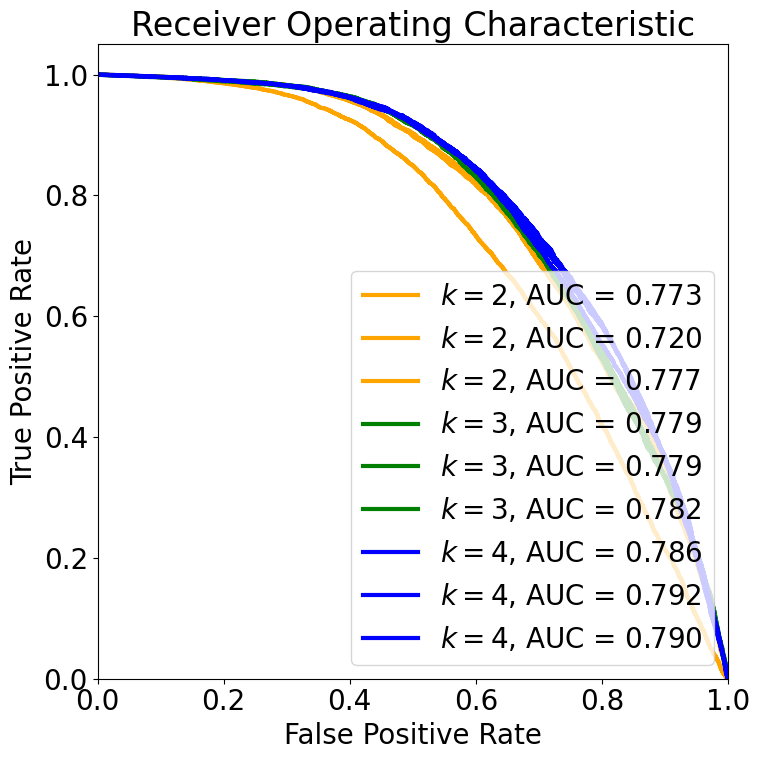

In [15]:


newplot()
colors = ["red", "orange", "green", "blue", "purple"]

for k in [2, 3, 4]:

    for i in range(num_models_to_train):


        (X_train, X_val, X_test, Y_train, Y_val, Y_test) = data_split(features[:, 0:2*(k+1)], Y, val=val, test=test)
        model = train_model(k)


        # Predict probabilities using the model
        y_pred_prob = model.predict(X_test)

        # Compute ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Save ROC curve data
        np.save(f"Data/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", np.array([fpr, tpr, thresholds, roc_auc]))

        # Plot ROC curve
    
        plt.plot(tpr, 1-fpr, color=colors[k-1], lw=3, label=f'$k = {k}$' +  ', AUC = %0.3f' % roc_auc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


$k = 1$ Log Ang. Closed Form& 0.731 $\pm$ 0.009 & 35.3 $\pm$ 1.8 & 6.9 $\pm$ 0.2 & $3+1$ \\
$k = 2$ Log Ang. Closed Form& 0.775 $\pm$ 0.002 & 55.6 $\pm$ 1.1 & 10.1 $\pm$ 0.1 & $3+3$ \\
$k = 3$ Log Ang. Closed Form& 0.780 $\pm$ 0.001 & 55.3 $\pm$ 1.8 & 12.0 $\pm$ 0.0 & $3+5$ \\
$k = 4$ Log Ang. Closed Form& 0.789 $\pm$ 0.003 & 54.7 $\pm$ 0.4 & 12.4 $\pm$ 0.2 & $3+7$ \\


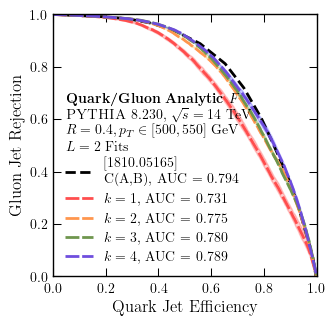

In [7]:
# Load and plot ROC curve data

newplot("column")


# ########## Digitized C(A,B) ##########
digitialized = np.genfromtxt("Data_old/original_efn_fit.csv", delimiter=",")
digitized_tpr = digitialized[:,0]
digitized_fpr = np.power(digitialized[:,1], 1.02)
digitized_auc =  auc(digitized_tpr, digitized_fpr)

plt.plot(digitized_tpr, digitized_fpr, color="black", lw=2, ls = "--", label="[1810.05165]\nC(A,B), AUC = %0.3f" % digitized_auc)


# Moments 
colors = ["red", "orange", "green", "blue", "purple"]
for k in [1, 2, 3, 4]:

    # Average ROC curve over multiple model
    x_axis = np.linspace(0, 1, 1000)
    fprs = []
    tprs = []
    aucs = []
    e30 = []
    e50 = []

    latex_line = f"$k = {k}$ Log Ang. Closed Form&"  # Start the LaTeX line
    for i in range(num_models_to_train):
            
            if k == 2 and i == 1:
                continue
            
            # Load ROC curve data
            fpr, tpr, thresholds, roc_auc = np.load(f"Data_old/analytic/roc_curve_data_k{k}_i{i}_O{k}_2.npy", allow_pickle=True)

            # Append to lists by interpolating 
            fprs.append(np.interp(x_axis, tpr, 1-fpr))
            tprs.append(x_axis)
            aucs.append(roc_auc)


                # print ROC table info



            num_parameters = 2 * (k) + 1 - 2



            e30.append(1/np.interp(0.3, tpr, fpr))
            e50.append(1/np.interp(0.5, tpr, fpr))

    aucs = np.asarray(aucs)
    e30 = np.asarray(e30)
    e50 = np.asarray(e50)

    # Format for LaTeX table
    latex_line += f" {np.mean(aucs):.3f} $\pm$ {np.std(aucs)/np.sqrt(1):.3f} & {np.mean(e30):.1f} $\pm$ {np.std(e30)/np.sqrt(num_models_to_train):.1f} & {np.mean(e50):.1f} $\pm$ {np.std(e50)/np.sqrt(num_models_to_train):.1f} & $3+{num_parameters}$ \\\\"
    print(latex_line)

    # Average ROC curve
    fpr_avg = np.average(fprs, axis=0)
    tpr_avg = np.average(tprs, axis=0)
    auc_avg = np.average(aucs)

    # Standard deviation of ROC curve
    fpr_std = np.std(fprs, axis=0)
    auc_std = np.std(aucs)    
    

    # Plot ROC curve with error band

    color = colors[k-1]

    # get rgb color from color name
    if color == "red":
        color = np.array((1, 0, 0))
    elif color == "orange":
        color = np.array((1, 0.5, 0))
    elif color == "green":
        color = np.array((0, 0.5, 0))
    elif color == "blue":
        color = np.array((0, 0, 1))

    magenta = np.array((1, .7, .7))
    magenta_weight = 0.75

    # mix color with magenta
    color = (magenta*magenta_weight + color) / (magenta_weight + 1)

    plt.plot(tpr_avg, fpr_avg, color=color, lw=2, label=f'$k = {k}$' +  ', AUC = %0.3f' % auc_avg, alpha = 0.99, ls = (0, (5, 1)))
    plt.fill_between(tpr_avg, fpr_avg - fpr_std, fpr_avg + fpr_std, color=colors[k-1], alpha=0.2)




# Stamp
line_0 = "Quark/Gluon Analytic $F$"
line_1 = r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
line_3 = "$L = 2$ Fits"
stamp(0.05, 0.675, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"fontsize": 9})




# axes labels
plt.xlabel('Quark Jet Efficiency')
plt.ylabel('Gluon Jet Rejection')

# axes limits
plt.xlim(0, 1)
plt.ylim(0, 1)

# make legend and show plot
plt.legend(loc='lower left', frameon=False, fontsize = 9)

plt.savefig(f"Plots/analytic_F2.pdf", bbox_inches = "tight")



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Model input and placeholders for w and c
input_shape = (4,)  
input_data = Input(shape=input_shape)

b1_i = tf.Variable(tf.random.normal((4,1), mean=0.0, stddev=1), trainable=True, name="bias_numerator")

w1_i = tf.Variable(tf.random.normal((4,1), mean=0.0, stddev=1), trainable=True, name="weights_numerator")
i
numerator = tf.reduce_sum(w1_i[:,0] * (input_data - b1_i[:,0])**2, axis = -1) 

# layer = tf.reduce_sum([layer, w_0])
output = tf.sigmoid(numerator)

# Build the model
model = Model(inputs=input_data, outputs=output)

# BCE loss
def custom_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true, y_pred, from_logits=False)



In [ ]:
import warnings
warnings.filterwarnings("ignore")

k_order = 4
(X_train, X_val, X_test,
    Y_train, Y_val, Y_test) = data_split(features[:,1:k_order+1], Y, val=val, test=test)

print(X_train.shape)
batch_size = 512

for epoch in range(100):

    for i in range(0, len(X_train), batch_size):
    
        x_batch = X_train[i:i+batch_size]
        y_batch = Y_train[i:i+batch_size]

        # Compute gradients with respect to w and c
        with tf.GradientTape() as tape:
            predictions = model(x_batch)
            loss = custom_loss(y_batch, predictions)

        gradients = tape.gradient(loss, [w1_i, b1_i])

        # Create an optimizer
        optimizer = Adam(learning_rate=0.001)

        # Apply gradients to variables
        optimizer.apply_gradients(zip(gradients, [w1_i, b1_i]))


    if (epoch + 1) % 1 == 0:
        y_pred = model(X_val)
        auc = roc_auc_score(Y_val, y_pred)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy()}, AUC: {auc}")


# Get the optimized values of w and c
optimized_w1 = w1_i.numpy()
optimized_b1 = b1_i.numpy()

print("Optimized w1_i:", optimized_w1)
print("Optimized b1:", optimized_b1)


(250000, 4)


ValueError: No gradients provided for any variable: (['weights_numerator:0', 'bias_numerator:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'weights_numerator:0' shape=(4, 1) dtype=float32, numpy=
array([[-1.0729703],
       [-1.3885167],
       [ 1.4634117],
       [-1.1090738]], dtype=float32)>), (None, <tf.Variable 'bias_numerator:0' shape=(4, 1) dtype=float32, numpy=
array([[1.0695764],
       [1.0508679],
       [1.0943109],
       [0.6410818]], dtype=float32)>)).